## Tutorial 5: Quantum Neural Network
#### Julien Rauch, January 2026

### 1 - Introduction
This time, we will use our quantum circuit (feature map) directly as a quantum neural network inserted in an optimization loop:

- Each input data vector is embedded into Hilbert space by the feature map of $n$ qubits with a set of parameters $\theta$ and produces an output quantum state of $n$ qubits. This is then measured to produce an output data vector of $2^n$ values (probabilities), that corresponds to the projection of $\ket{\phi_{\theta}(x)} = U(x, \theta)\ket{0}^n$.

- The CPU then clusters the data based on projections of the quantum states of each input data point. This clustering is evaluated using an NMI metric based on the known labels for each input data point. Finally, a Cobyla optimizer experiments with new sets of parameters $\theta$ to obtain new embeddings, then new clusters, and ultimately achieve a better NMI metric.

### 2 - Quantum Circuit Design: Feature Map as QNN

We will create a circuit consisting of the embedding section from the previous tutorial, and we will add a parametric section consisting of $Ry$ gates and $controled~Rz$ gates connected circularly (inspired of EfficientSU2 feature map). 

Here is the circuit in question for a single layer:

![image](./img/circuit_var.png)

In [36]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

In [43]:
def embbeding_parametric_circuit(nb_qubit, nb_feature, name_param="parameters", name_input="input", nb_layer=1):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        name_param : name will be the identifier of the ParameterVector corresponding to the parameters
        name_input : name will be the identifier of the ParameterVector corresponding to the input
        nb_layer : number of layers in the circuit
        This function returns the embedding and variational circuit.
    """
    #TODO create the embedding circuit

    # Create parameter vectors for inputs and parameters
    input_params = ParameterVector(name_input, nb_feature)
    param_params = ParameterVector(name_param, nb_layer * nb_qubit * 2)
    circuit = QuantumCircuit(nb_qubit)

    if nb_qubit>1:
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            for i in range(nb_qubit):
                circuit.rz(input_params[i % nb_feature], i)
                circuit.ry(param_params[i], i)
            for i in range(nb_qubit):
                circuit.cx(i, (i + 1) % nb_qubit)
                circuit.rz(param_params[nb_qubit + i], (i + 1) % nb_qubit)
                circuit.cx(i, (i + 1) % nb_qubit)
                

    else:
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            for i in range(nb_qubit):
                circuit.rz(input_params[i % nb_feature], i)
                circuit.ry(param_params[i], i)

    

    
    return circuit

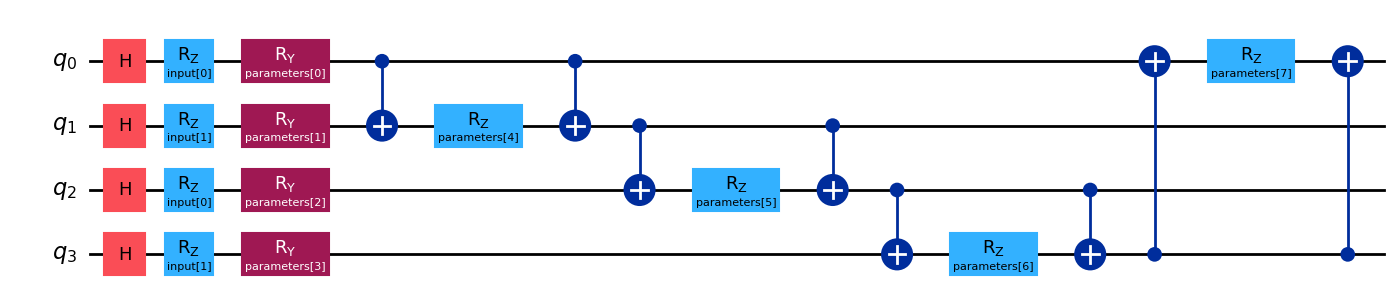

In [44]:
# Print the circuit
embbeding_parametric_circuit(4,2).draw('mpl') # Basic printing, you can improve

### 3 - Global Data Embedding Function

We need a function that acheving the **data embedding loop**:

- Successively load the input data vectors with fixed parameters $\theta$ defined in the quantum circuit, then store and return the projections of the output quantum states.

In [111]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

nb_shots = 2048 #1024 by default
sim = AerSimulator(shots=nb_shots)

# create the pass manager (managing and optimizing the quantum circuit)
pm = generate_preset_pass_manager(backend=sim, optimization_level=1)

In [67]:
def embedding_data(nb_qubit, nb_feature, dataset, parameters, backend, pass_manager, nb_layer=1):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        dataset : data to embedded
        parameters : parameters of the variational circuit
        backend : backend to run the circuit
        pass_manager : pass manager to transpose the circuit by adapting it to the backend
        nb_layer : number of layers in the circuit
        This function returns the embedded data
    """
    res = []       # list of output quantum state projection
    n = len(dataset) # number of projections

    # Create the base circuit with parameters
    base_circuit = embbeding_parametric_circuit(nb_qubit, nb_feature, nb_layer=nb_layer)
    
    # Add measurements to all qubits
    base_circuit.measure_all()
    
    # Get parameter objects from the circuit
    input_param_list = [p for p in base_circuit.parameters if 'input' in p.name]
    theta_param_list = [p for p in base_circuit.parameters if 'parameters' in p.name]
    
    # Sort them to ensure correct order
    input_param_list = sorted(input_param_list, key=lambda p: p.index)
    theta_param_list = sorted(theta_param_list, key=lambda p: p.index)
    
    # Loop through each data point in the dataset
    for data_point in dataset:
        # Create parameter dictionary
        param_dict = {}
        
        # Bind input features
        for i, param in enumerate(input_param_list):
            if i < len(data_point):
                param_dict[param] = data_point[i]
        
        # Bind theta parameters (variational parameters)
        for i, param in enumerate(theta_param_list):
            if i < len(parameters):
                param_dict[param] = parameters[i]
        
        # Assign all parameters at once
        qc_bound = base_circuit.assign_parameters(param_dict)
        
        # Transpile the circuit
        qc_transpiled = pass_manager.run(qc_bound)
        
        # Run the circuit on the backend
        sampler = Sampler(backend)
        job = sampler.run([qc_transpiled])
        result = job.result()
        
        # Extract probability distribution
        counts = result[0].data.meas.get_counts()
        
        # Convert counts to probability distribution (normalized)
        total_shots = sum(counts.values())
        prob_dist = np.zeros(2**nb_qubit)
        
        for bitstring, count in counts.items():
            # Convert bitstring to integer index
            idx = int(bitstring, 2)
            prob_dist[idx] = count / total_shots
        
        res.append(prob_dist)
    
    return np.array(res)

In [68]:
# Execution of the data embedding loop on a small dataset with random theta parameters
embedding_data(1, 1, [[0.2], [0.8], [3.4]], np.random.random(1), sim, pm)

array([[0.11132812, 0.88867188],
       [0.22460938, 0.77539062],
       [0.89941406, 0.10058594]])

### 4 - Data Clustering using outputs of the Quantum Neural Network

In this section, we aim to perform a data clustering using the projections provided by our previous parametric circuit (QNN) with random parameters.

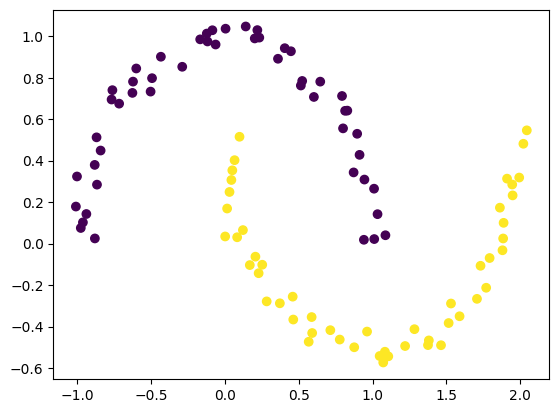

In [69]:
from sklearn.datasets import make_moons
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

# Importing the "moons" dataset and the associated labels
X_moons, y_moons = make_moons(100, noise=0.05)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)

Do the clustering like in the previous tutorial (for the parameters uses ```np.random.random``` for now).

NMI Score with random parameters: 0.1733


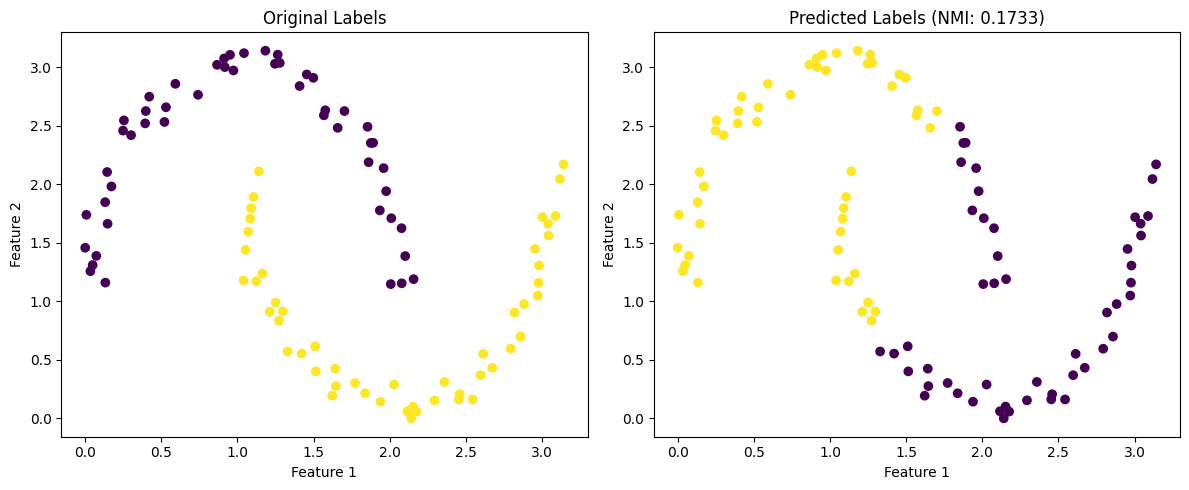

In [70]:
# TODO Do the preprocessing
# Scale the moons dataset to [0, pi]
scaler = preprocessing.MinMaxScaler(feature_range=(0, np.pi))
X_moons = scaler.fit_transform(X_moons)

# TODO Call your data embedding function and run a spectral clustering 
# Define circuit parameters
nb_qubit = 2
nb_feature = 2
nb_layer = 1

# Calculate number of parameters needed
params_per_layer = nb_qubit * 2 if nb_qubit > 1 else nb_qubit
nb_params = params_per_layer * nb_layer

# Initialize random parameters
random_params = np.random.random(nb_params) * np.pi  # Scale to [0, pi] for better performance

# Embed the data using the QNN
embedded_data = embedding_data(nb_qubit, nb_feature, X_moons, random_params, sim, pm, nb_layer=nb_layer)

# Perform spectral clustering
clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = clustering.fit_predict(embedded_data)

# TODO Compute and print the NMI result
nmi = normalized_mutual_info_score(y_moons, cluster_labels)
print(f"NMI Score with random parameters: {nmi:.4f}")

# TODO Display the dataset with computed labeling
plt.figure(figsize=(12, 5))

# Original labels
plt.subplot(1, 2, 1)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
plt.title("Original Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Predicted labels
plt.subplot(1, 2, 2)
plt.scatter(X_moons[:,0], X_moons[:,1], c=cluster_labels)
plt.title(f"Predicted Labels (NMI: {nmi:.4f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

## 5 - Complete classification algorithm:
### - Use of previous data clustering 
### - Optimization of embedding performed by QNN

This section is devoted to the implementation and experimentation of the complete ML algorithm in order to obtain optimal classification.

### 5.1 - Display Function

In [71]:
from IPython.display import clear_output
from scipy.optimize import minimize

score_evolution = []

#This function will display the result of our classification and the evolution of the score (NMI) at each loop (epoch).
def plot_training_progress(cluster_labels_save):

    if len(score_evolution) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # NMI
    ax1.set_title("Classification Score")
    ax1.plot(score_evolution)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("NMI")

    # Labeling
    ax2.set_title("Labeling")
    ax2.scatter(X_moons[:,0], X_moons[:,1], c=cluster_labels_save)

    plt.show()

### 5.2 - Design of the objective function

To optimize the classification we first design an "objective function" that takes as parameters those that must be supplied to our circuit ($\theta$ parameters) and returns a score that we want to minimize, we will use the ```minimize``` function from the ```scipy.optimize``` module. 
This objective function will be used at the next section.

In [72]:
def f_objective(parameter):
    # Call data embedding function
    embedded_data = embedding_data(nb_qubit, nb_feature, X_moons, parameter, sim, pm, nb_layer=nb_layer)
    
    # Run spectral clustering
    clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
    cluster_labels = clustering.fit_predict(embedded_data)
    
    # Compute the NMI result
    nmi = normalized_mutual_info_score(y_moons, cluster_labels)

    # We store the NMI score in the global score list and call the previously defined plot_training_progress function, 
    # which will display the progress of our training
    score_evolution.append(nmi)
    plot_training_progress(cluster_labels)

    # Return the score to minimize (we want to maximize NMI, so minimize -NMI)
    return -nmi

### 5.3 - Run the learning loop

Use the ```minimize``` function from the ```scipy.optimize``` module on the previous objective function.

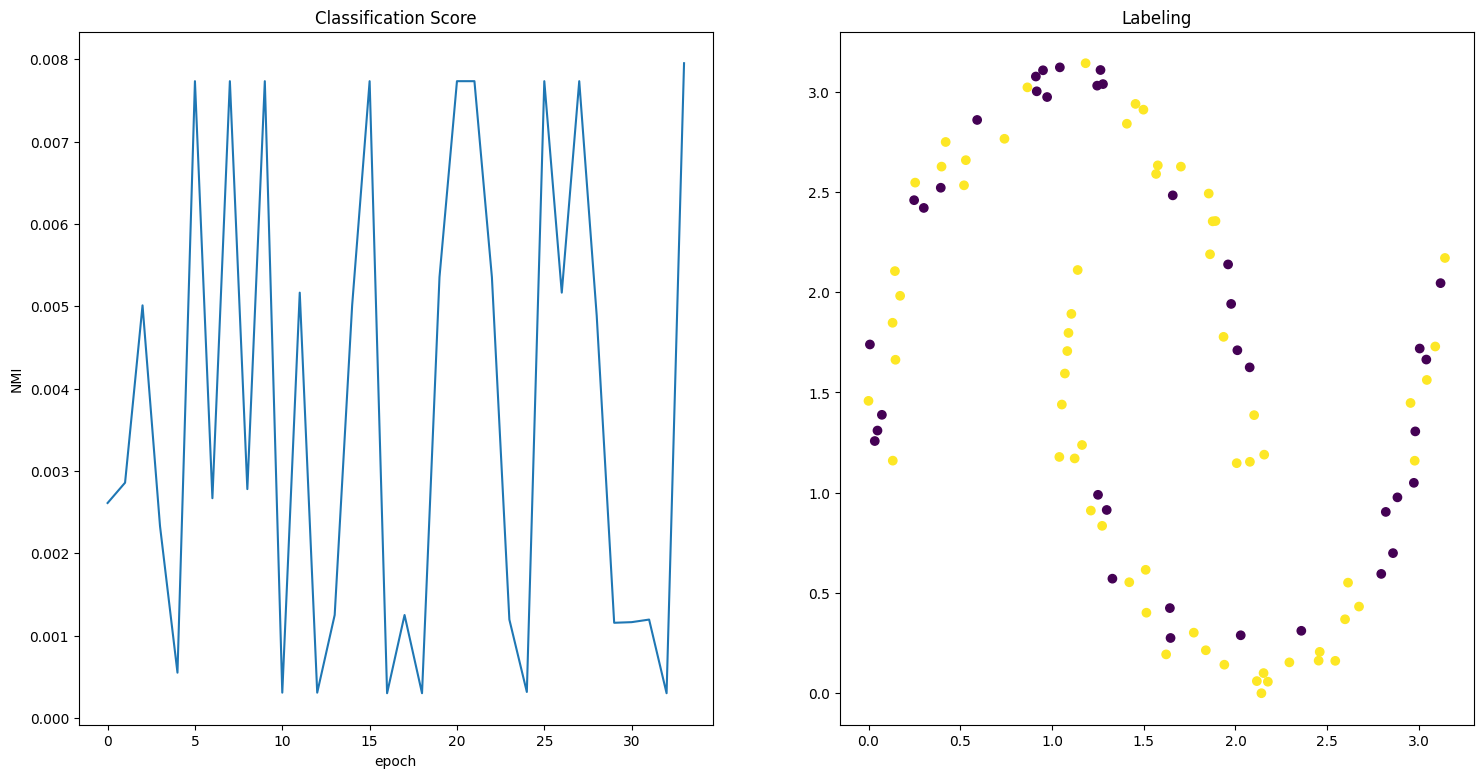

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [153]:
# Section 5.3 - IMPROVED VERSION

# We initialize the score list to store the evolution of the NMI.
score_evolution = []

# Circuit parameters - INCREASE LAYERS for more expressivity
nb_qubit = 2
nb_feature = 2
nb_layer = 3  # INCREASED from 1 to 3
params_per_layer = nb_qubit * 2 if nb_qubit > 1 else nb_qubit
nb_params = params_per_layer * nb_layer

print(f"Number of parameters: {nb_params}")

# Better initialization: small random values around 0
x0 = np.random.uniform(-0.1, 0.1, nb_params)  # Scale down for better convergence

# Run minimize with better settings
res = minimize(
    f_objective, 
    x0, 
    method='COBYLA', 
    options={
        'maxiter': 75,  # More iterations
        'tol': 1e-6       # Tolerance
    }
)

print(f"\nOptimization completed!")
print(f"Best NMI score: {-res.fun:.4f}")
print(f"Number of iterations: {len(score_evolution)}")

Display the final result


Final NMI Score: 0.6705
Improvement from initial: 0.6702


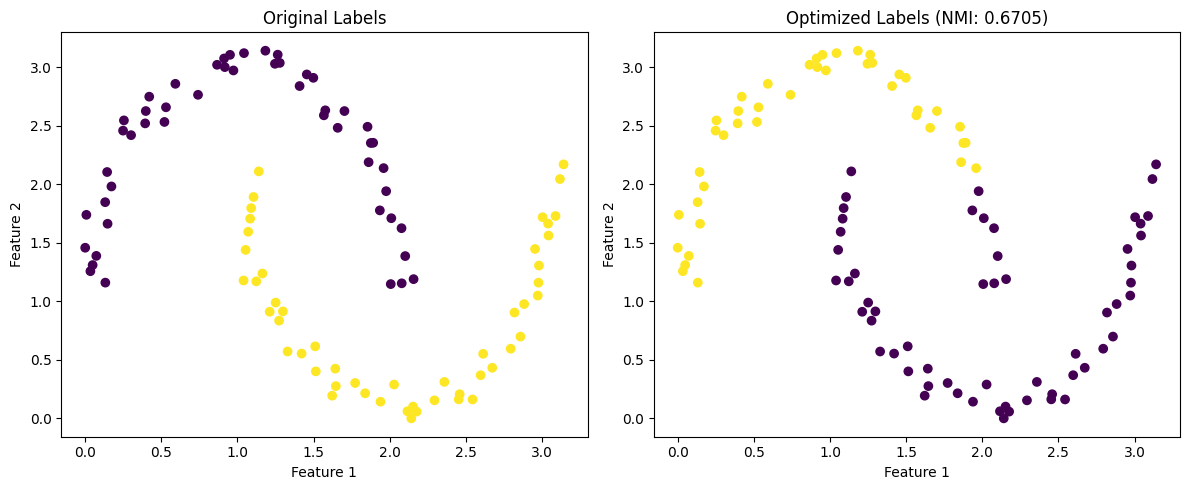

In [134]:
# TODO: call your data embedding function and run a spectral clustering with the optimized parameters
embedded_data = embedding_data(nb_qubit, nb_feature, X_moons, res.x, sim, pm, nb_layer=nb_layer)

# Run spectral clustering with optimized parameters
clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = clustering.fit_predict(embedded_data)

# TODO Compute and print the NMI result
nmi_final = normalized_mutual_info_score(y_moons, cluster_labels)
print(f"\nFinal NMI Score: {nmi_final:.4f}")
print(f"Improvement from initial: {nmi_final - score_evolution[0]:.4f}")

# TODO Display the dataset with computed labeling
plt.figure(figsize=(12, 5))

# Original labels
plt.subplot(1, 2, 1)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons, cmap='viridis')
plt.title("Original Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Optimized predicted labels
plt.subplot(1, 2, 2)
plt.scatter(X_moons[:,0], X_moons[:,1], c=cluster_labels, cmap='viridis')
plt.title(f"Optimized Labels (NMI: {nmi_final:.4f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()